In [1]:
%pip install qiskit > /dev/null 2>&1
%pip install qiskit_ibm_runtime > /dev/null 2>&1
%pip install qiskit_aer > /dev/null 2>&1
%pip install matplotlib > /dev/null 2>&1
%pip install pylatexenc > /dev/null 2>&1
%pip install qiskit-transpiler-service > /dev/null 2>&1
%pip install networkx > /dev/null 2>&1
%pip install torch > /dev/null 2>&1

In [2]:
import qiskit
import numpy as np
qiskit.__version__

'1.2.0'

In [3]:
import networkx as nx
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.visualization import plot_histogram, plot_state_city
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from qiskit_aer import AerSimulator
from qiskit.circuit.library import CUGate
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.primitives import StatevectorSampler, PrimitiveJob
from qiskit import transpile
import matplotlib.pyplot as plt
from torch import Tensor
from typing import List, Union, Tuple

Number of nodes: 5


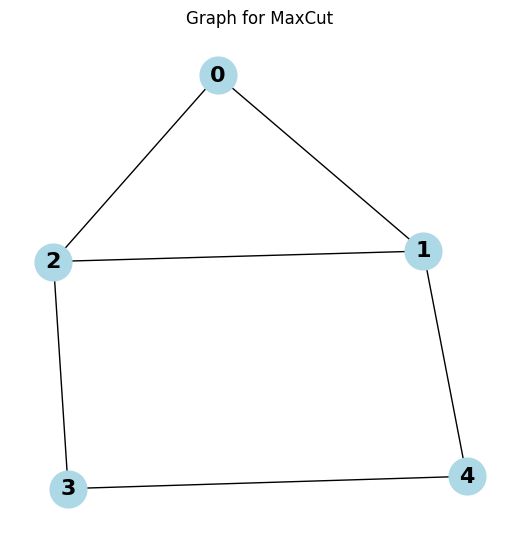

In [4]:
# Define a small graph for MaxCut
G = nx.Graph()
# G.add_edges_from([(0, 1), (1, 2), (2, 0)])  # Triangle graph

#G.add_edges_from([(0,1),(1,2),(2,3),(3,0),(0,2),(1,3)])

G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 4), (1, 4), (0,2)])  # A hexagon with a diagonal

# Number of vertices
n = G.number_of_nodes()
print("Number of nodes:", n)

# Draw the graph
plt.figure(figsize=(5, 5))
nx.draw(G, with_labels=True, node_color='lightblue', font_weight='bold', node_size=700, font_size=16)
plt.title("Graph for MaxCut")
plt.show()

In [5]:
def cnx(qc, qubits):
    if len(qubits) > 3:
        last = qubits[-1]

        # A matrix: (made up of a Z rotation and U3 gate)
        qc.crz(np.pi/2, qubits[-2], qubits[-1])
        qc.cu(np.pi / 2, 0, 0, 0, qubits[-2], qubits[-1])

        # Recursive call for the smaller set of qubits
        cnx(qc, [qubits[:-2], qubits[-1]])

        # B matrix (opposite angle)
        qc.cu(-np.pi / 2, 0, 0, 0, qubits[-2], qubits[-1])

        # Another recursive call for the smaller set of qubits
        cnx(qc, [qubits[:-2], qubits[-1]])

        # C matrix (final Z rotation)
        qc.crz(-np.pi/2, qubits[-2], qubits[-1])

    elif len(qubits) == 3:
        qc.ccx(qubits[0], qubits[1], qubits[2])

    elif len(qubits) == 2:
        qc.cx(qubits[0], qubits[1])

# Test on 5 Qubits
# qc = QuantumCircuit(5)
# cnx(qc, [0, 1, 2, 3, 4])
# qc.draw('mpl')

In [6]:
def increment_gate(qwc, q, subnode):

  cnx(qwc, [subnode[0], q[2], q[1], q[0]])
  cnx(qwc, [subnode[0], q[2], q[1]])
  cnx(qwc, [subnode[0], q[2]])
  qwc.barrier()
  return qwc

def decrement_gate(qwc, q, subnode):

  qwc.x(subnode[0])
  qwc.x(q[2])
  qwc.x(q[1])
  cnx(qwc, [subnode[0], q[2], q[1], q[0]])
  qwc.x(q[1])
  cnx(qwc, [subnode[0], q[2], q[1]])
  qwc.x(q[2])
  cnx(qwc, [subnode[0], q[2]])
  qwc.x(subnode[0])
  return qwc

# def ibmsim(circ, measure_all):
#   sampler = StatevectorSampler()
#   pub = circ
#   job_sampler = sampler.run([pub], shots=256)
#   result_sampler = job_sampler.result()
#   if measure_all:
#     c_counts_sampler = result_sampler[0].data.meas.get_counts()
#     canc_counts_sampler = {'0': 0}
#   else:
#     c_counts_sampler = result_sampler[0].data.cr.get_counts()
#     canc_counts_sampler = result_sampler[0].data.canc.get_counts()
#   return c_counts_sampler, canc_counts_sampler

def ibmsim(circ):
    # Use AerSimulator to simulate the circuit with measurements
    simulator = AerSimulator()

    # Transpile the circuit for the simulator
    transpiled_circ = transpile(circ, simulator)

    # Run the transpiled circuit
    result = simulator.run(transpiled_circ, shots=1024).result()

    # Get the measurement results
    c_counts_sampler = result.get_counts()

     # store counts
    possibilities = {k: v for k, v in c_counts_sampler.items()}

    # Sort the results by probability in descending order
    sorted_possibilities = sorted(possibilities.items(), key=lambda x: x[1], reverse=True)

    return c_counts_sampler, sorted_possibilities

def binary_map_edge(edge, num_qubits):
    """Maps an edge to qubit indices based on binary encoding."""
    node1, node2 = edge
    bin_node1 = bin(node1)[2:].zfill(num_qubits)
    bin_node2 = bin(node2)[2:].zfill(num_qubits)

    # Find the qubits that differ (these are the ones involved in the edge)
    differing_bits = [i for i in range(num_qubits) if bin_node1[i] != bin_node2[i]]
    return differing_bits

def adjusted_phase_oracle(qwc, graph, num_qubits):
    """Applies the phase oracle using qubit indices based on the graph edges."""
    for edge in graph.edges:
        qubit_indices = binary_map_edge(edge, num_qubits)
        if len(qubit_indices) == 2:
            # Apply a controlled-Z gate between the two qubits involved in this edge
            qwc.cz(qubit_indices[0], qubit_indices[1])
    return qwc

def efficient_phase_oracle(qwc, graph, num_qubits):
    """Applies a phase oracle using qubit indices based on the graph edges."""
    for edge in graph.edges:
        qubit_indices = binary_map_edge(edge, num_qubits)
        if len(qubit_indices) == 2:
            # Apply a controlled-Z gate between the two qubits involved in this edge
            qwc.cz(qubit_indices[0], qubit_indices[1])
        elif len(qubit_indices) > 2:
            # Apply a multi-controlled Z gate (if the edge mapping involves more than two qubits)
            cnx(qwc, qubit_indices + [0])  # Assuming the last qubit is the target
    return qwc

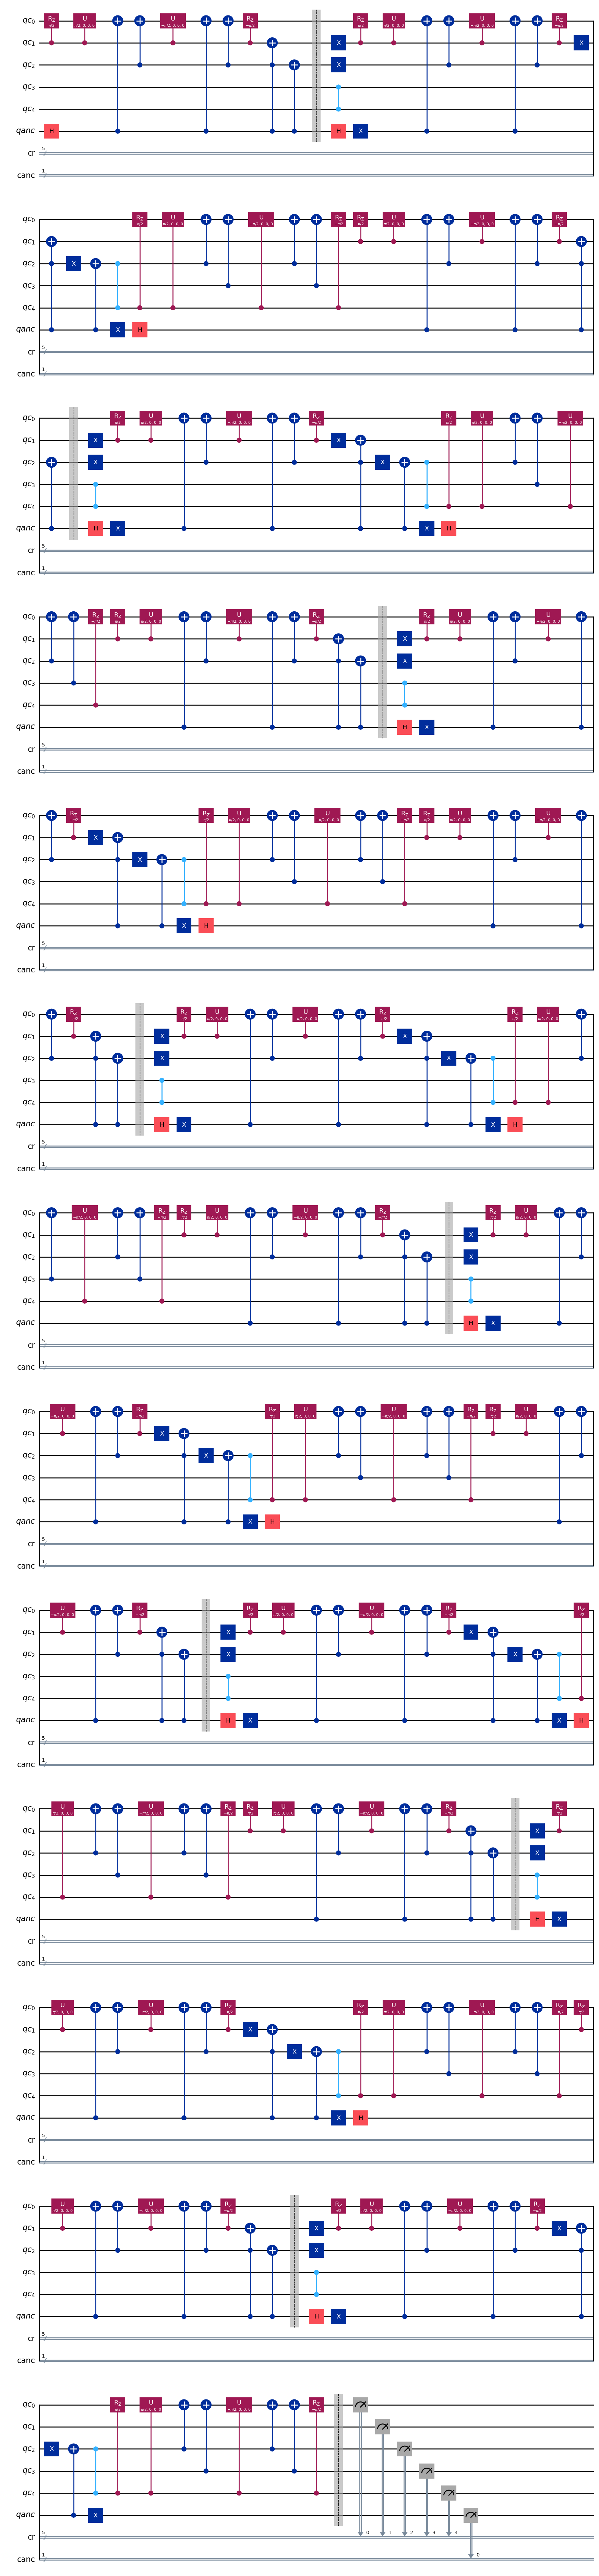

In [7]:
qnodes = QuantumRegister(n,'qc')
qsubnodes = QuantumRegister(1,'qanc')
csubnodes = ClassicalRegister(1,'canc')
cnodes = ClassicalRegister(n,'cr')

qwc = QuantumCircuit(qnodes, qsubnodes, cnodes, csubnodes)

def runQWC(qwc, graph, times, num_qubits):
    for i in range(times):
        qwc.h(qsubnodes[0])
        qwc = increment_gate(qwc, qnodes, qsubnodes)
        qwc.h(qsubnodes[0])
        qwc = decrement_gate(qwc, qnodes, qsubnodes)
        qwc = efficient_phase_oracle(qwc, graph, num_qubits) # Improved phase oracle
        # qwc = adjusted_phase_oracle(qwc, graph, num_qubits)  # Apply the phase oracle

    return qwc

# def runQWC(qwc, graph, steps, num_qubits):
#     """Runs the quantum walk circuit with the improved oracle."""
#     for i in range(steps):
#         qwc.h(range(num_qubits))  # Apply Hadamard gates to create superposition
#         qwc = increment_gate(qwc, qnodes, qsubnodes)  # Increment gate
#         qwc = efficient_phase_oracle(qwc, graph, num_qubits)  # Improved phase oracle
#         qwc = decrement_gate(qwc, qnodes, qsubnodes)  # Decrement gate
#         qwc.h(range(num_qubits))  # Apply Hadamard gates again

#     return qwc


step = 8
qwc = runQWC(qwc, G, step, n)
qwc.barrier()
qwc.measure(qnodes, cnodes)
qwc.measure(qsubnodes[0], csubnodes[0])
# qwc.measure_all()
# qwc.measure(qnodes[0], cnodes[0])
# qwc.measure(qnodes[1], cnodes[1])
# qwc.measure(qnodes[2], cnodes[2])
# qwc.measure(qsubnodes[0], csubnodes[0])
qwc.draw(output="mpl")

{'1 00100': 1, '1 00101': 277, '0 00111': 167, '0 00011': 33, '0 00100': 36, '1 00011': 23, '0 00110': 31, '0 00010': 68, '1 00110': 230, '0 00000': 43, '1 00111': 2, '1 00001': 51, '0 00001': 1, '1 00010': 13, '1 00000': 47, '0 00101': 1}


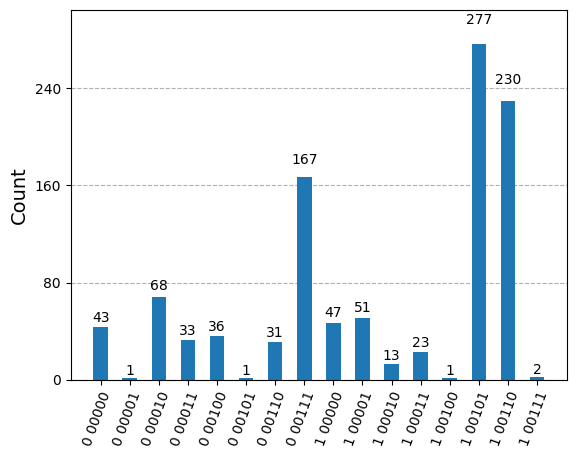

In [8]:
# c_result, canc_result = ibmsim(qwc, False)
c_result, cut_possibilities = ibmsim(qwc)
print(c_result)
plot_histogram(c_result)

In [9]:
print(cut_possibilities)
# plot_histogram(cut_probabilities)

[('1 00101', 277), ('1 00110', 230), ('0 00111', 167), ('0 00010', 68), ('1 00001', 51), ('1 00000', 47), ('0 00000', 43), ('0 00100', 36), ('0 00011', 33), ('0 00110', 31), ('1 00011', 23), ('1 00010', 13), ('1 00111', 2), ('1 00100', 1), ('0 00001', 1), ('0 00101', 1)]


In [10]:
'''
transfer_nxgraph_to_adjacencymatrix and obj_maxcut come from https://github.com/zhumingpassional/Maxcut_CSCI
  created by:
  - Prof. Liu and
  - zhumingpassional Ming Zhu
'''

def transfer_nxgraph_to_adjacencymatrix(graph: nx.Graph):
    return nx.to_numpy_array(graph)

def obj_maxcut(result: Union[Tensor, List[int], np.array], graph: nx.Graph):
    num_nodes = len(result)
    obj = 0
    adj_matrix = transfer_nxgraph_to_adjacencymatrix(graph)
    # we compare every node in the sequence with every other node
    # then check if they were originally connected
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if result[i] != result[j]:
                obj += adj_matrix[(i, j)] # if they are connected then this adds 1

                # print(result[i], result[j], "add", adj_matrix[(i, j)])
                # print("(i, j):", (i, j))

    return obj


# print(cut_possibilities[0])
for i in range(len(cut_possibilities)):
    num = cut_possibilities[i][0][2:]
    binary_sequence = [int(bit) for bit in num]
    # print(binary_sequence)
    print("cut value:", obj_maxcut(binary_sequence, G), "(" + str(cut_possibilities[i][0][2:] + ", " + str(cut_possibilities[i][1])) + ")")

# cut_value = obj_maxcut(cut_possibilities[0][0], G)
# print("cut value:", cut_value)

cut value: 5.0 (00101, 277)
cut value: 3.0 (00110, 230)
cut value: 3.0 (00111, 167)
cut value: 2.0 (00010, 68)
cut value: 2.0 (00001, 51)
cut value: 0 (00000, 47)
cut value: 0 (00000, 43)
cut value: 3.0 (00100, 36)
cut value: 2.0 (00011, 33)
cut value: 3.0 (00110, 31)
cut value: 2.0 (00011, 23)
cut value: 2.0 (00010, 13)
cut value: 3.0 (00111, 2)
cut value: 3.0 (00100, 1)
cut value: 2.0 (00001, 1)
cut value: 5.0 (00101, 1)
